<a href="https://colab.research.google.com/github/maggiecope/comp351-ai-project/blob/main/Comp351FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# STEP 1: Import libraries and load the dataset (SVR Model)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("Wait_Times.csv")

# Preview the dataset
df.head()


,Land,Ride,Wait Time,Local Time,Day of Week,Date,tempmax,tempmin,temp,humidity,...,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description
0,Pixar Pier,Toy Story Midway Mania!,40,2024-09-23 17:30:04,Monday,2024-09-23,78.4,62.4,67.9,80.5,...,5.6,210.0,18.0,8,10,2024-09-23 6:40:56,2024-09-23 18:46:15,0.69,Partially cloudy,Clearing in the afternoon.
1,Cars Land,Mater's Graveyard JamBOOree,30,2024-09-23 17:45:03,Monday,2024-09-23,78.4,62.4,67.9,80.5,...,5.6,210.0,18.0,8,10,2024-09-23 6:40:56,2024-09-23 18:46:15,0.69,Partially cloudy,Clearing in the afternoon.
2,Hollywood Land,Mickey's PhilharMagic,10,2024-09-23 17:45:03,Monday,2024-09-23,78.4,62.4,67.9,80.5,...,5.6,210.0,18.0,8,10,2024-09-23 6:40:56,2024-09-23 18:46:15,0.69,Partially cloudy,Clearing in the afternoon.
3,Pixar Pier,Jumpin' Jellyfish,20,2024-09-23 17:45:03,Monday,2024-09-23,78.4,62.4,67.9,80.5,...,5.6,210.0,18.0,8,10,2024-09-23 6:40:56,2024-09-23 18:46:15,0.69,Partially cloudy,Clearing in the afternoon.
4,Avengers Campus,WEB SLINGERS: A Spider-Man Adventure,45,2024-09-23 18:00:04,Monday,2024-09-23,78.4,62.4,67.9,80.5,...,5.6,210.0,18.0,8,10,2024-09-23 6:40:56,2024-09-23 18:46:15,0.69,Partially cloudy,Clearing in the afternoon.


In [10]:
# STEP 2: Convert timestamps and engineer time-based features (SVR Model)

# Convert timestamps to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Local Time"] = pd.to_datetime(df["Local Time"], errors="coerce")
df["sunrise"] = pd.to_datetime(df["sunrise"], errors="coerce")
df["sunset"] = pd.to_datetime(df["sunset"], errors="coerce")

# Engineer numeric time features
df["hour"] = df["Local Time"].dt.hour
df["minute"] = df["Local Time"].dt.minute
df["time_in_minutes"] = df["hour"] * 60 + df["minute"]

df["day_of_week_num"] = df["Date"].dt.weekday
df["day_of_year"] = df["Date"].dt.dayofyear
df["month"] = df["Date"].dt.month

# Preview engineered features
df[[
    "Date", "Local Time", "hour", "minute",
    "time_in_minutes", "day_of_week_num",
    "day_of_year", "month"
]].head()


,Date,Local Time,hour,minute,time_in_minutes,day_of_week_num,day_of_year,month
0,2024-09-23,2024-09-23 17:30:04,17,30,1050,0,267,9
1,2024-09-23,2024-09-23 17:45:03,17,45,1065,0,267,9
2,2024-09-23,2024-09-23 17:45:03,17,45,1065,0,267,9
3,2024-09-23,2024-09-23 17:45:03,17,45,1065,0,267,9
4,2024-09-23,2024-09-23 18:00:04,18,0,1080,0,267,9


In [11]:
# STEP 3: Drop unusable columns and one-hot encode categorical variables (SVR Model)

# Columns SVR cannot use directly
drop_cols = ["Local Time", "Date", "sunrise", "sunset", "description"]

# Drop those columns if they exist
drop_cols = [c for c in drop_cols if c in df.columns]
df = df.drop(columns=drop_cols)

# One-hot encode all categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Confirm everything is now numeric
df_encoded.dtypes.head(20)


Wait Time             int64
tempmax             float64
tempmin             float64
temp                float64
humidity            float64
precip              float64
windgust            float64
windspeed           float64
winddir             float64
sealevelpressure    float64
cloudcover          float64
visibility          float64
solarradiation      float64
solarenergy         float64
uvindex               int64
severerisk            int64
moonphase           float64
hour                  int32
minute                int32
time_in_minutes       int32
dtype: object

In [12]:
# STEP 4: Subsample data, then train-test split and scale (SVR on smaller dataset)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Subsample to, for example, 30,000 rows
df_small = df_encoded.sample(30000, random_state=42)

# Separate features and target on the subsample
X = df_small.drop(columns=["Wait Time"])
y = df_small["Wait Time"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((24000, 66), (6000, 66))

In [13]:
# STEP 5: Fit SVR model on subsample and evaluate performance

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

y_pred_train_svr = svr_model.predict(X_train_scaled)
y_pred_test_svr = svr_model.predict(X_test_scaled)

train_rmse_svr = np.sqrt(mean_squared_error(y_train, y_pred_train_svr))
test_rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_test_svr))
train_r2_svr = r2_score(y_train, y_pred_train_svr)
test_r2_svr = r2_score(y_test, y_pred_test_svr)

print("SVR Model Performance (RBF Kernel, Subsampled):")
print(f"Train RMSE: {train_rmse_svr:.4f}")
print(f"Test RMSE:  {test_rmse_svr:.4f}")
print(f"Train R²:   {train_r2_svr:.4f}")
print(f"Test R²:    {test_r2_svr:.4f}")


SVR Model Performance (RBF Kernel, Subsampled):
Train RMSE: 15.4127
Test RMSE:  15.4030
Train R²:   0.6076
Test R²:    0.5930


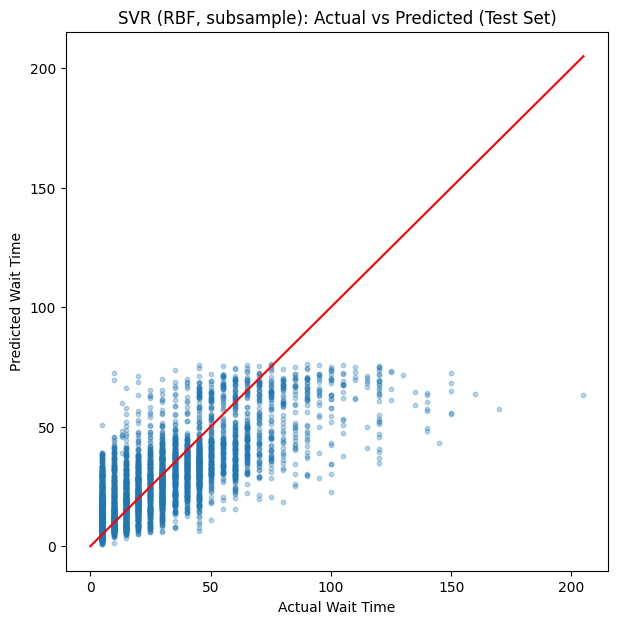

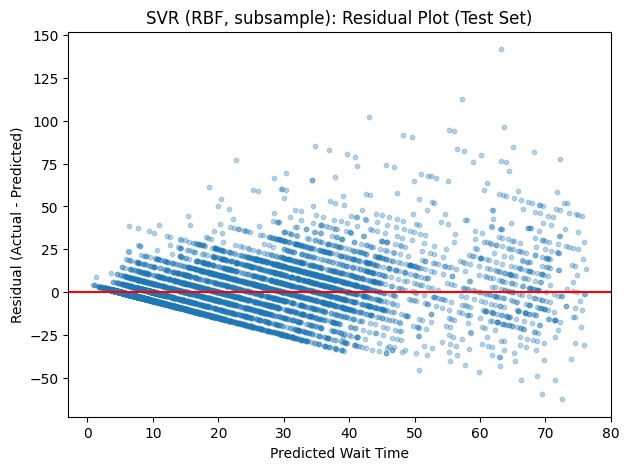

In [14]:
# STEP 6: Visualize SVR predictions (Actual vs Predicted + Residuals)

import matplotlib.pyplot as plt

# 1. Actual vs Predicted (Test Set)
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_test_svr, alpha=0.3, s=10)
plt.xlabel("Actual Wait Time")
plt.ylabel("Predicted Wait Time")
plt.title("SVR (RBF, subsample): Actual vs Predicted (Test Set)")
plt.plot([0, max(y_test)], [0, max(y_test)], color="red")  # perfect prediction line
plt.show()

# 2. Residual Plot (Test Set)
residuals_svr = y_test - y_pred_test_svr

plt.figure(figsize=(7,5))
plt.scatter(y_pred_test_svr, residuals_svr, alpha=0.3, s=10)
plt.axhline(0, color="red")
plt.xlabel("Predicted Wait Time")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("SVR (RBF, subsample): Residual Plot (Test Set)")
plt.show()



In [15]:
# STEP 7: Fast SVR hyperparameter tuning on smaller subset

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# 1. Force a smaller subset from the fully encoded data
#    This ignores any previous df_small and guarantees we only use 10,000 rows.
df_small = df_encoded.sample(10000, random_state=42)

# 2. Train/test split on the subset
X_small = df_small.drop(columns=["Wait Time"])
y_small = df_small["Wait Time"]

X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42
)

# 3. Scale features for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Subset shapes:", X_train_scaled.shape, X_test_scaled.shape)

# 4. Lightweight hyperparameter grid
C_values = [0.5, 1, 2]
epsilon_values = [0.1]          # fixed epsilon for speed
gamma_values = ["scale", 0.01]  # small gamma grid

results = []
total = len(C_values) * len(epsilon_values) * len(gamma_values)
count = 0

for C in C_values:
    for epsilon in epsilon_values:
        for gamma in gamma_values:
            count += 1
            print(f"Fitting model {count}/{total}  (C={C}, eps={epsilon}, gamma={gamma})")

            svr_tuned = SVR(kernel="rbf", C=C, epsilon=epsilon, gamma=gamma)
            svr_tuned.fit(X_train_scaled, y_train)

            preds = svr_tuned.predict(X_test_scaled)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            r2 = r2_score(y_test, preds)

            results.append({
                "C": C,
                "epsilon": epsilon,
                "gamma": gamma,
                "Test RMSE": rmse,
                "Test R²": r2
            })

# 5. Show results sorted by best RMSE
tuning_df = pd.DataFrame(results).sort_values("Test RMSE")
tuning_df


Subset shapes: (8000, 66) (2000, 66)
Fitting model 1/6  (C=0.5, eps=0.1, gamma=scale)
Fitting model 2/6  (C=0.5, eps=0.1, gamma=0.01)
Fitting model 3/6  (C=1, eps=0.1, gamma=scale)
Fitting model 4/6  (C=1, eps=0.1, gamma=0.01)
Fitting model 5/6  (C=2, eps=0.1, gamma=scale)
Fitting model 6/6  (C=2, eps=0.1, gamma=0.01)


,C,epsilon,gamma,Test RMSE,Test R²
4,2.0,0.1,scale,16.841880,0.573403
5,2.0,0.1,0.01,16.912243,0.569831
2,1.0,0.1,scale,17.804392,0.523250
3,1.0,0.1,0.01,17.819419,0.522445
1,0.5,0.1,0.01,19.002109,0.456950
0,0.5,0.1,scale,19.043090,0.454605


In [16]:
# STEP 8: Final tuned SVR model using best hyperparameters

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Best params from Step 7:
best_C = 2.0
best_epsilon = 0.1
best_gamma = "scale"

svr_final = SVR(
    kernel="rbf",
    C=best_C,
    epsilon=best_epsilon,
    gamma=best_gamma
)

# Fit on the same small subset (X_train_scaled, y_train from Step 7)
svr_final.fit(X_train_scaled, y_train)

# Predictions
y_pred_train_svr_final = svr_final.predict(X_train_scaled)
y_pred_test_svr_final = svr_final.predict(X_test_scaled)

# Metrics
train_rmse_svr_final = np.sqrt(mean_squared_error(y_train, y_pred_train_svr_final))
test_rmse_svr_final = np.sqrt(mean_squared_error(y_test, y_pred_test_svr_final))
train_r2_svr_final = r2_score(y_train, y_pred_train_svr_final)
test_r2_svr_final = r2_score(y_test, y_pred_test_svr_final)

print("Final Tuned SVR (RBF, subsample) Performance:")
print(f"Best hyperparameters: C={best_C}, epsilon={best_epsilon}, gamma={best_gamma}")
print(f"Train RMSE: {train_rmse_svr_final:.4f}")
print(f"Test RMSE:  {test_rmse_svr_final:.4f}")
print(f"Train R²:   {train_r2_svr_final:.4f}")
print(f"Test R²:    {test_r2_svr_final:.4f}")


Final Tuned SVR (RBF, subsample) Performance:
Best hyperparameters: C=2.0, epsilon=0.1, gamma=scale
Train RMSE: 15.3549
Test RMSE:  16.8419
Train R²:   0.6051
Test R²:    0.5734
